In [1]:
import numpy as np 
import torch 
import ase
from ase.visualize import view
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

Atomistic simulations form one of the cornerstones of research in condensed matter physics, chemistry, and materials science. All properties of a given atomic configuration $A$, or equivalently a collection of its $N$ nuclear positions and charges, are encoded within the electronic Hamiltonian ($\hat{H}$) which is a quantum mechanical (QM) operator. Electronic energies $\varepsilon$, along with the wavefunctions $\psi$ from which other properties may be derived, are obtained as solutions of the Time-Independent Schrödinger's equation (TISE), 
$$ \hat{H} |\psi \rangle = \varepsilon |\psi \rangle, $$
where $\hat{H}$ is the Hamiltonian operator decribing the physics of the interaction, $|\psi \rangle$ is the energy eigenstate and $\varepsilon$, is the corresponding eigenvalue. 

Beyond the TISE, a lot of problems in physics can be formulated as eigenvalue problems, such as determining the modes of vibration in materials, spin interactions (via Heisenberg or Hubbard Hamiltonians), or photonic band structures. 

Even though the TISE takes a deceptively simple form, it is very hard to solve it analytically or even approximately for many-body systems. As a result, a large portion of computational quantum physics is dedicated to finding approximate methods for solving or simplifying the eigenvalue problem. A lot of ML effort has been spent in bypassing this process. Instead of solving the Schrödinger equation from first principles, one can train ML models to directly learn structure–property relationships, for example learning to predict energies or band gaps (difference of eigenvalues) directly from input structures. 

Below, we will encounter some examples of such surrogate models starting from simple two-level Hamiltonians, which allow us to visually and analytically understand the impact of symmetries and distortions. We will observe the effect of structural distortions on eigenvalues (e.g., gap opening via eigenvalue repulsion), construct synthetic atomic configurations and band gaps and contrast two modeling approached. We will learn the bandgap directly from atomic structure, and compare it to learning the underlying Hamiltonian matrix and using its eigenspectrum to recover target property.

Can you think of benefits/limitations of one approach versus the other?

## Two-Level System 

Rather than working with abstract operators directly, we represent $\hat{H}$ as a matrix on a _basis_. Let $\left\{\left|\phi_i\right\rangle\right\}$ be a set of linearly independent states (or orbitals), then the matrix elements of $\hat{H}$ can be obtained as 
$$
\mathbf{H}_{i j}=\left\langle\phi_i\right| \hat{H}\left|\phi_j\right\rangle
$$
Note that the matrix corresponding to the Hamiltonian is Hermitian (i.e. $\mathbf{H} = \mathbf{H}^\dagger $). 

A 2×2 Hermitian Hamiltonian can represent many physical systems such as coupled quantum dots, spin 1/2 particles in magnetic fields, or electronic interactions in molecules. Consider the Hamiltonian of a two-level quantum system with some coupling $V$.

$$ 
\mathbf{H}(\Delta_1, \Delta_2,  V) = \begin{pmatrix}
\Delta_1 & V \\
V & \Delta_2
\end{pmatrix}
$$

In writing this matrix, we chose a basis of two orthonormal states $|1\rangle$ and $|2\rangle$, in which, the diagonal elements $\Delta_1$ and $\Delta_2$ represent the on-site energies or _uncoupled_ energy levels, and the off-diagonal element $V$ represents the coupling or tunneling amplitude between the two states.

Thus, the matrix

$$
\mathbf{H}=\underbrace{\left(\begin{array}{cc}
\Delta_1 & 0 \\
0 & \Delta_2
\end{array}\right)}_{\text {Unperturbed }}+\underbrace{\left(\begin{array}{cc}
0 & V \\
V & 0
\end{array}\right)}_{\text {Coupling interaction }}
$$



The eigenvalues of $\mathbf{H}$ are obtained as, 

$$
\varepsilon =  \frac{(\Delta_1+\Delta_2)\pm \sqrt{(\Delta_1+\Delta_2)^2 - 4 (\Delta_1 \Delta_2) V^2}}{2}
$$

When $V \neq 0$, the energy levels repel and do not cross — this is _level repulsion_ or the formation of a _band gap_.  What is the minimum energy gap we can obtain in such a system? As $\Delta$ is varied, the minimum energy gap is \(2V\).


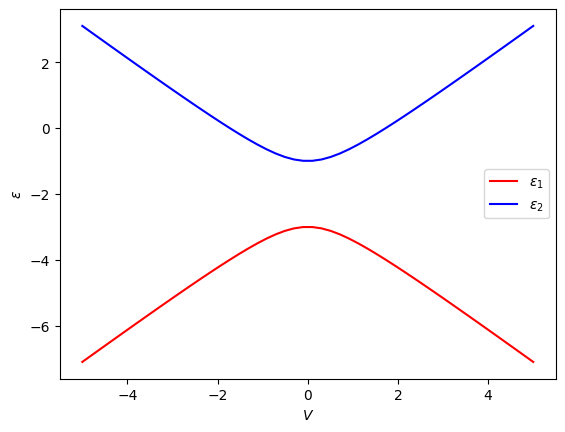

In [2]:
M = torch.zeros(2,2, dtype = torch.float64)
delta1 = -3
delta2 = -1
M[0,0] = delta1
M[1,1] = delta2
couplings = np.linspace(-5,5)
evals = []
for eps in couplings:
    M[0,1] = M[1,0] = eps
    e = torch.linalg.eigvalsh(M)
    evals.extend(e)
plt.plot(couplings, evals[::2], 'r', label = r'$\varepsilon_1$')
plt.plot(couplings, evals[1::2], 'b', label = r'$\varepsilon_2$')
plt.xlabel(r'$V$')
plt.ylabel(r'$\varepsilon$')
plt.legend()

# plt.axhline(y = energy1, c='k', ls = '--')
# plt.axhline(y = energy2, c='k', ls = '--')


### Eigenvalue Crossing

Now consider the case where the off-diagonal coupling vanishes:

$$
H(\Delta, \eta, V=0) = \begin{pmatrix}
\Delta & 0 \\
0 & -\Delta + \eta
\end{pmatrix}
$$
If $\eta = 0$, the eigenvalues are simply $\varepsilon = \pm \Delta$. Hence, the two energy levels cross exactly at $\Delta = 0$. This happens when two quantum states are completely uncoupled or _symmetry-forbidden_ to mix.


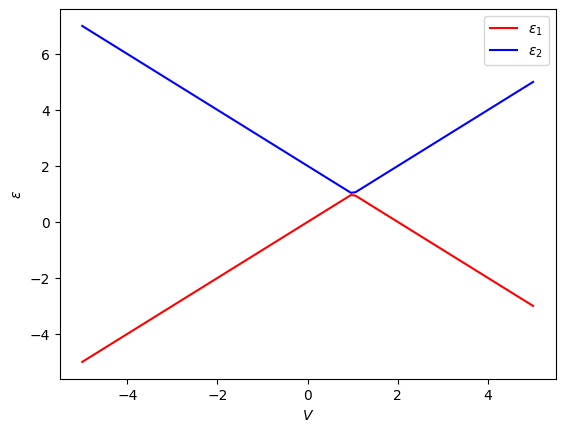

In [3]:
M = torch.zeros(2,2, dtype = torch.float64)
couplings = np.linspace(-5,5, 100)
OFFSET = 2
evals = []
for eps in couplings:
    M[0,0] = eps
    M[1,1] = -1*eps +OFFSET
    e = torch.linalg.eigvalsh(M)
    evals.extend(e)
plt.plot(couplings, evals[::2], 'r', label = r'$\varepsilon_1$')
plt.plot(couplings, evals[1::2], 'b', label = r'$\varepsilon_2$')
plt.xlabel(r'$V$')
plt.ylabel(r'$\varepsilon$')
plt.legend()

What happens if $\eta$ is non-zero? Can you explain this behavior?

# H chains

We generate a set of 2×2 Hermitian (symmetric) matrices, corresponding to the displacement of 2 Hydrogen atoms. 

In [16]:
from ase import Atoms
def make_diatomic(distance: float):
    return Atoms('H2', positions=[[0, 0, 0], [distance, 0, 0]])

distances = np.linspace(0.5, 3.0, 100)
frames = [make_diatomic(d) for d in distances]

# you can visualize the structure we computed above by uncommenting the next line
# view(frames) # this launches an interactive ASE visualization window

def hopping(distance, alpha=1.5):
    return -np.exp(-alpha * distance)

def make_hamiltonian(alpha = 1.5, delta1=0.0, delta2=1.0, distance=0.0):
    t = hopping(distance, alpha = alpha)
    # mimics an effective orbital energy shift due to varying electronic environments
    return np.array([[delta1+ 0.2 * np.sin(4 * np.pi * distance), t],
                     [t, delta2+ 0.1 * np.cos(2 * np.pi * distance)]])

DELTA1 = -0.5
DELTA2 = -0.125
DTYPE=torch.float64
hamiltonians = np.array([make_hamiltonian(delta1 = DELTA1, delta2 = DELTA2, distance = d) for d in distances])
eigvals = np.linalg.eigvalsh(hamiltonians)
gaps = eigvals[:, 1] - eigvals[:, 0]


X = torch.tensor(distances[:, None], dtype=DTYPE)  # inputs to the model 
Y_gap = torch.tensor(gaps, dtype=DTYPE)  
Y_H = torch.tensor(hamiltonians, dtype=DTYPE)  

Text(0, 0.5, '$\\Delta \\epsilon$')

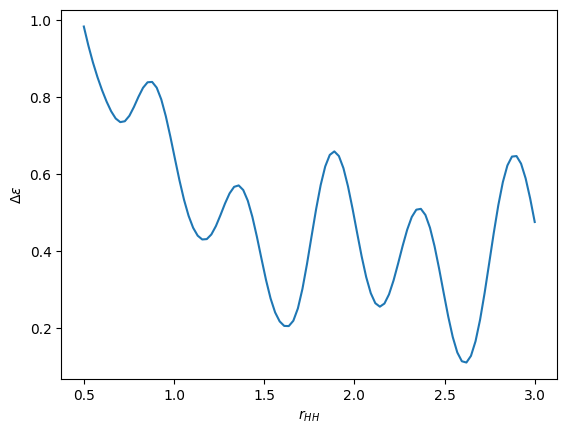

In [46]:
plt.plot(distances, gaps)
plt.xlabel(r'$r_{HH}$')
plt.ylabel(r'$\Delta \epsilon$')
# plt.plot(eigvals[:,0], 'r')
# plt.plot(eigvals[:,1], 'b')

### Learning the Eigenvalue Gap Directly

We train a simple MLP to predict the energy gap $\Delta \varepsilon = \varepsilon _2 - \varepsilon _1 $ from the displacement between two H atoms.


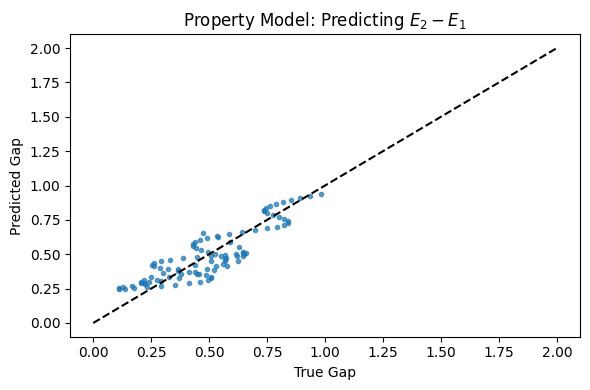

In [43]:
dataset = TensorDataset(X, Y_gap)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

class GapPredictor(nn.Module):
    def __init__(self, nhidden=16,activation = 'SiLU'):
        super().__init__()
        if isinstance(activation, str):
            try:
                activation= getattr(nn, activation)()
            except:
                raise ValueError("Invalid activation function name.")
        else:
            assert callable(activation)
            
        self.model = nn.Sequential(
            nn.Linear(1, nhidden),
            activation,
            nn.Linear(nhidden, nhidden),
            activation,
            nn.Linear(nhidden, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

NHIDDEN = 200
ACTIVATION = 'SiLU'
model = GapPredictor(nhidden = NHIDDEN, activation=ACTIVATION)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

NEPOCHS = 1000
for epoch in range(NEPOCHS):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




model.eval()
with torch.no_grad():
    preds = model(X)

plt.figure(figsize=(6,4))
plt.plot(gaps, preds, '.', alpha=0.7)
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Property Model: Predicting $E_2 - E_1$")
# plt.grid(True)
plt.plot([0,2], [0,2], 'k--')
plt.tight_layout()
plt.show()



### Learning the intermediate matrix 

Now let's try to model the intermediate Hamiltonian instead. 
How many independent entries are there in a symmetric 2x2 matrix? 

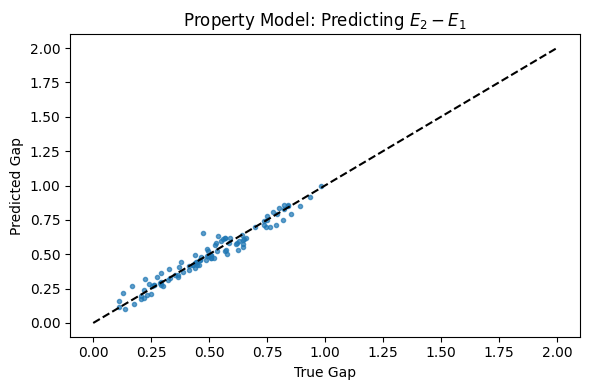

In [42]:
class HamiltonianPredictor(nn.Module):
    def __init__(self, nhidden=16, activation = 'SiLU', dtype = torch.float64):
        super().__init__()
        if isinstance(activation, str):
            try:
                activation= getattr(nn, activation)()
            except:
                raise ValueError("Invalid activation function name.")
        else:
            assert callable(activation)
            
        self.model = nn.Sequential(
            nn.Linear(1, nhidden),
            activation,
            nn.Linear(nhidden, nhidden),
            activation,
            nn.Linear(nhidden, 3)
        )
        self.dtype = dtype
    
    def forward(self, x):
        out = self.model(x)
        Hs = torch.zeros(x.shape[0], 2,2, dtype=self.dtype)
        Hs[:,0,0] = out[:, 0]
        Hs[:,1,1] = out[:, 2]
        Hs[:,0,1] = out[:, 1]
        Hs[:,1,0] = out[:, 1]
    
        return Hs

NHIDDEN = 200
ACTIVATION = 'SiLU'
model = HamiltonianPredictor(nhidden = NHIDDEN, activation=ACTIVATION)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

dataset = TensorDataset(X, Y_H)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

NEPOCHS = 2000
for epoch in range(NEPOCHS):
    for xb, yb in loader:
        pred = model(xb)
        pred_eigvals = torch.linalg.eigvalsh(pred)
        true_eigvals = torch.linalg.eigvalsh(yb)
        loss = loss_fn(true_eigvals, pred_eigvals)
        # loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    predHs = model(X)
    
pred_eigvals = np.linalg.eigvalsh(predHs)
pred_gaps = pred_eigvals[:, 1] - pred_eigvals[:, 0]

plt.figure(figsize=(6,4))
plt.plot(gaps, pred_gaps, '.', alpha=0.7)
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Property Model: Predicting $E_2 - E_1$")
# plt.grid(True)
plt.plot([0,2], [0,2], 'k--')
plt.tight_layout()
plt.show()

What if in the examples above, we chose a basis in which each H atom was represented not by one state, but instead by two states? F
What if, instead of representing each hydrogen atom with one state (or orbital), we included two orbitals per atom? Then our basis would not just be

$$
\left|\phi_1\right\rangle = \text { orbital on H1, } \quad\left|\phi_2\right\rangle= \text { orbital on H2 }
$$

but instead

$$
\{\left|\phi_1\right\rangle, \left|\phi_2\right\rangle\} \text{ on H1}, \quad\{\left|\phi_3\right\rangle, \left|\phi_4\right\rangle\} \text{ on H2}
$$

Now we have 4 basis states, so the Hamiltonian becomes a $4 \times 4$ matrix.
The diagonal terms of the matrix convey the energy of each orbital, whearas the off-diagonal terms indicate how much each orbitals interact with the other. 

Remember, each orbital can accommodate two electrons and the band-gap, is defined as the difference of the highest occupied orbital and the lowest unoccupied orbital. How would you model the band gap in this case?
                                                                                                                                                        

What if the model was not aware of the Hermitian constraint of the Hamiltonian? Modify the code and discuss your observations

# Benzene 
Let us crank up the complexity slightly and look at benzene molecule, which is a very symmetric molecule. Do you know what symmetry group it corresponds to?

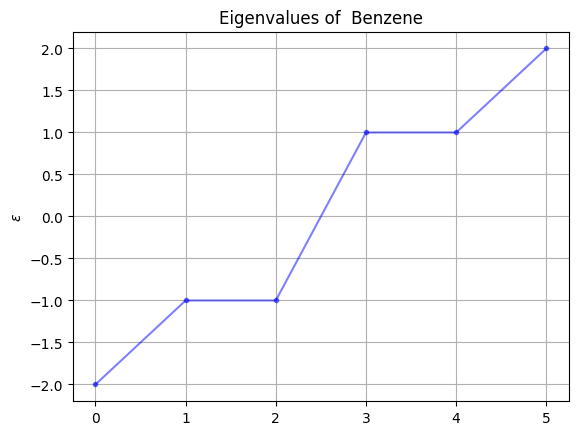

In [99]:

def benzene_coords(R=1.0):
    angles = np.linspace(0, 2*np.pi, 7)[:-1]
    return np.stack([R * np.cos(angles), R * np.sin(angles)], axis=-1)

def apply_distortion(coords, mode='E2g', epsilon=0.1):
    if mode == 'E2g':
        # One real E2g component 
        displacement_vectors = np.array([
            [ 1,  0],
            [ 0.5, -np.sqrt(3)/2],
            [-0.5, -np.sqrt(3)/2],
            [-1,  0],
            [-0.5,  np.sqrt(3)/2],
            [ 0.5,  np.sqrt(3)/2]
        ])
        return coords + epsilon * displacement_vectors

    elif mode == 'A1g':
        # Radial symmetric breathing mode (all atoms push out/in equally)
        displaced = []
        for i in range(len(coords)):
            r_hat = coords[i] / np.linalg.norm(coords[i])
            displaced.append(coords[i] + epsilon * r_hat)
        return np.array(displaced)

    else:
        raise ValueError(f"Unknown mode: {mode}. Choose 'E2g' or 'A1g'.")


def compute_hamiltonian(coords, t0=1.0, alpha=5.0, d0=None):
    N = len(coords)
    if d0 is None:
        d0 = np.linalg.norm(coords[0] - coords[1])
    H = np.zeros((N, N))
    for i in range(N):
        j = (i + 1) % N
        d = np.linalg.norm(coords[i] - coords[j])
        t = t0 * np.exp(-alpha * (d - d0))
        H[i, j] = H[j, i] = -t
    return H



benzene = benzene_coords()
d0 = np.linalg.norm(benzene[0] - benzene[1])  
H = compute_hamiltonian(benzene,t0=1.0, alpha=3.0, d0=d0)
eigvals = np.linalg.eigvalsh(H)

plt.plot(eigvals, 'b.-', alpha = 0.5, label = 'pure')
plt.title("Eigenvalues of  Benzene")
plt.ylabel(r"$\varepsilon$")
plt.grid(True)
plt.show()

Notice that the eigenvalues appear in certain degeneracies, owing to the symmetric nature of the structure. Depending on how we distort the structure of the molecule, we can either preserve the degeneracy or break it entirely! Below, we consider two different modes of distortions

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/k9/q06q1_g56p78b5klqcvmw1mw0000gn/T/ipykernel_10373/3682591780.py:14: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel("Distortion strength ($\delta$)")


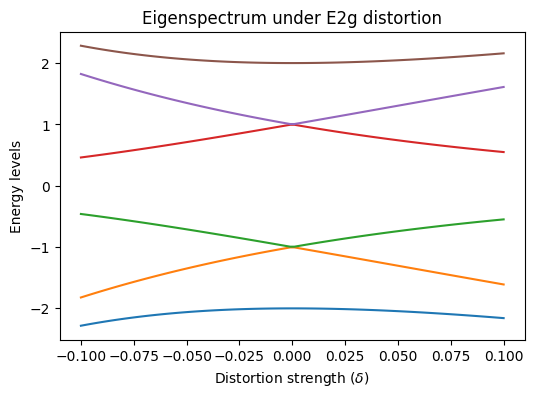

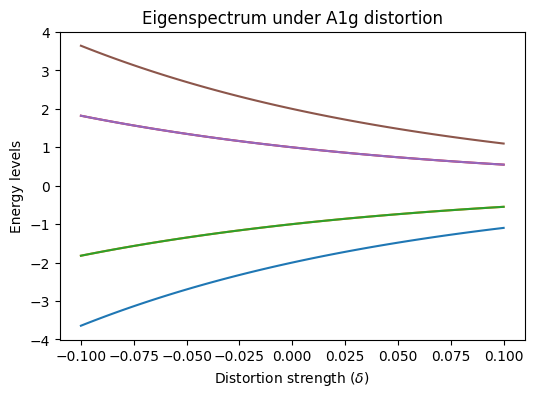

In [104]:
def plot_eigenspectra(mode, epsilon_range=np.linspace(-0.1, 0.1, 100), R=1.0):
    coords_0 = benzene_coords(R)
    d0 = np.linalg.norm(coords_0[0] - coords_0[1])
    eigs = []
    for eps in epsilon_range:
        distorted = apply_distortion(coords_0, mode=mode, epsilon=eps)
        H = compute_hamiltonian(distorted, t0=1.0, alpha=6.0, d0=d0)
        eigvals = np.linalg.eigvalsh(H)
        eigs.append(eigvals)

    eigs = np.array(eigs)
    plt.figure(figsize=(6, 4))
    plt.plot(epsilon_range, eigs)
    plt.xlabel("Distortion strength ($\delta$)")
    plt.ylabel("Energy levels")
    plt.title(f"Eigenspectrum under {mode} distortion")
    plt.show()

plot_eigenspectra(mode='E2g')
plot_eigenspectra(mode='A1g')

Visualize the structural distortions accompanying both these plots. How is the structure distorted in the first plot? What about the second?

In [105]:
def generate_dataset(mode='E2g', N=100, eps_range=(0, 0.3), dtype = torch.float64):
    epsilons = np.linspace(*eps_range, N)
    coords_0 = benzene_coords()
    d0 = np.linalg.norm(coords_0[0] - coords_0[1])
    X = epsilons[:, None]
    Y = []
    for eps in epsilons:
        coords = apply_distortion(coords_0, mode=mode, epsilon=eps)
        H = compute_hamiltonian(coords, alpha=6.0, d0=d0)
        Y.append(np.linalg.eigvalsh(H))  # ground truth
    Y = np.array(Y)
    return torch.tensor(X, dtype=dtype), torch.tensor(Y, dtype=dtype)


In [106]:
class EigenvaluePredictor(nn.Module):
    def __init__(self, nhidden=64, activation='SiLU'):
        super().__init__()
        act = getattr(nn, activation)() if isinstance(activation, str) else activation
        self.model = nn.Sequential(
            nn.Linear(1, nhidden),
            act,
            nn.Linear(nhidden, nhidden),
            act,
            nn.Linear(nhidden, 6)  # predict 6 eigenvalues directly
        )

    def forward(self, x):  # x: [batch_size, 1]
        return self.model(x)  # [batch_size, 6]

class HamiltonianPredictor6x6(nn.Module):
    def __init__(self, nhidden=64, activation='SiLU', dtype=torch.float64):
        super().__init__()
        act = getattr(nn, activation)() if isinstance(activation, str) else activation
        self.model = nn.Sequential(
            nn.Linear(1, nhidden),
            act,
            nn.Linear(nhidden, nhidden),
            act,
            nn.Linear(nhidden, 21)  # independent entries of symmetric 6×6
        )
        self.dtype = dtype

    def forward(self, x):  # x: [batch_size, 1]
        out = self.model(x)  # [batch_size, 21]
        batch_size = x.shape[0]
        H = torch.zeros(batch_size, 6, 6, dtype=self.dtype, device=x.device)

        idx = 0
        for i in range(6):
            for j in range(i, 6):
                H[:, i, j] = out[:, idx]
                H[:, j, i] = out[:, idx]
                idx += 1

        eigvals = torch.linalg.eigvalsh(H)  # [batch_size, 6], sorted
        return eigvals

def train_model(model, train_loader, test_loader, epochs=500, lr=1e-3):
    model = model.to(torch.float64)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in train_loader) / len(train_loader)
            test_loss  = sum(loss_fn(model(xb), yb).item() for xb, yb in test_loader) / len(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

    return train_losses, test_losses


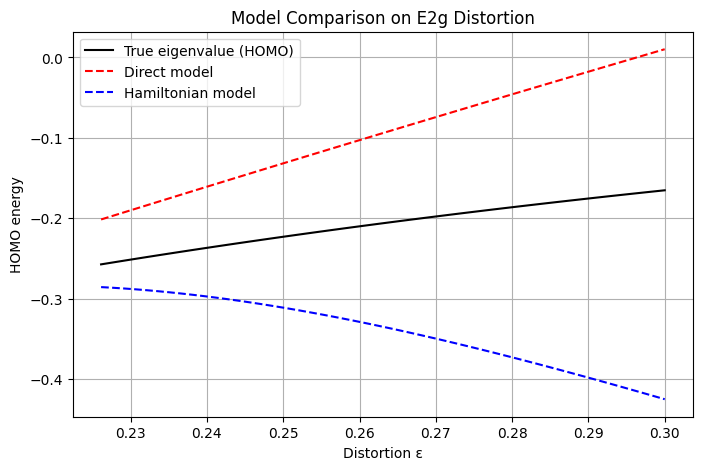

In [107]:
X, Y = generate_dataset(mode='E2g', N=200)
X_train, X_test = X[:150], X[150:]
Y_train, Y_test = Y[:150], Y[150:]

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, Y_test), batch_size=32)

# Models
model_direct = EigenvaluePredictor(nhidden=64)
model_ham    = HamiltonianPredictor6x6(nhidden=64)

# Train both
losses_direct = train_model(model_direct, train_loader, test_loader, epochs=500)
losses_ham    = train_model(model_ham, train_loader, test_loader, epochs=500)

# Final evaluation
model_direct.eval()
model_ham.eval()
with torch.no_grad():
    pred_direct = model_direct(X_test)
    pred_ham    = model_ham(X_test)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_test.squeeze(), Y_test[:, 2], 'k-', label='True eigenvalue (HOMO)')
plt.plot(X_test.squeeze(), pred_direct[:, 2], 'r--', label='Direct model')
plt.plot(X_test.squeeze(), pred_ham[:, 2], 'b--', label='Hamiltonian model')
plt.xlabel("Distortion ε")
plt.ylabel("HOMO energy")
plt.title("Model Comparison on E2g Distortion")
plt.legend()
plt.grid(True)
plt.show()

So what else is the model targeting the intermediate operator good for? 

In [57]:


# # Example: tight-binding Hamiltonian for distorted benzene
# # Assume H is a Hermitian matrix of shape (n_sites, n_sites)
# # For simplicity, we'll use a 6x6 matrix to represent a distorted benzene

# # Sample distorted Hamiltonian
# H = np.array([
#     [0.0, -1.0,  0.0,  0.0,  0.0, -0.8],
#     [-1.0, 0.0, -1.0,  0.0,  0.0,  0.0],
#     [0.0, -1.0,  0.0, -1.2,  0.0,  0.0],
#     [0.0,  0.0, -1.2,  0.0, -1.0,  0.0],
#     [0.0,  0.0,  0.0, -1.0,  0.0, -1.0],
#     [-0.8, 0.0,  0.0,  0.0, -1.0,  0.0]
# ])

# Diagonalize the Hamiltonian
e_vals, e_vecs = np.linalg.eigh(H)

# Sort eigenvalues and eigenvectors
idx = np.argsort(e_vals)
e_vals = e_vals[idx]
e_vecs = e_vecs[:, idx]

# Assume half-filling (3 lowest levels occupied)
n_occ = 3
rho = sum(np.outer(e_vecs[:, i], e_vecs[:, i].conj()) for i in range(n_occ))

# Compute site charges (diagonal of density matrix)
site_charges = np.real(np.diag(rho))

# Compute bond orders (off-diagonal elements)
bond_orders = np.real(rho)

# Output key matrices and charge vectors
rho, site_charges, bond_orders


(array([[ 5.00000000e-01,  3.66139089e-01,  5.55111512e-17,
         -1.65923508e-01,  4.16333634e-17,  2.97340809e-01],
        [ 3.66139089e-01,  5.00000000e-01,  2.99769686e-01,
         -2.56739074e-16, -1.61493970e-01,  3.46944695e-17],
        [ 5.55111512e-17,  2.99769686e-01,  5.00000000e-01,
          3.64153161e-01,  7.63278329e-17, -1.65923508e-01],
        [-1.65923508e-01, -2.56739074e-16,  3.64153161e-01,
          5.00000000e-01,  2.99769686e-01, -1.38777878e-16],
        [ 4.16333634e-17, -1.61493970e-01,  7.63278329e-17,
          2.99769686e-01,  5.00000000e-01,  3.66139089e-01],
        [ 2.97340809e-01,  3.46944695e-17, -1.65923508e-01,
         -1.38777878e-16,  3.66139089e-01,  5.00000000e-01]]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 array([[ 5.00000000e-01,  3.66139089e-01,  5.55111512e-17,
         -1.65923508e-01,  4.16333634e-17,  2.97340809e-01],
        [ 3.66139089e-01,  5.00000000e-01,  2.99769686e-01,
         -2.56739074e-16, -1.61493970e-01,  3.46944

In [59]:
rho@rho - rho

array([[-1.11022302e-16, -1.11022302e-16, -9.59678718e-17,
         0.00000000e+00,  2.98084476e-17,  0.00000000e+00],
       [-1.11022302e-16, -1.66533454e-16, -1.66533454e-16,
        -5.77304414e-17,  0.00000000e+00, -3.71036684e-17],
       [-9.59678718e-17, -1.66533454e-16, -2.22044605e-16,
        -2.22044605e-16, -6.80712049e-17, -2.77555756e-17],
       [ 0.00000000e+00, -5.77304414e-17, -2.22044605e-16,
        -1.66533454e-16, -1.11022302e-16, -3.71283002e-17],
       [ 2.98084476e-17,  0.00000000e+00, -6.80712049e-17,
        -1.11022302e-16, -1.11022302e-16,  0.00000000e+00],
       [ 0.00000000e+00, -3.71036684e-17, -2.77555756e-17,
        -3.71283002e-17,  0.00000000e+00,  0.00000000e+00]])

# Bases with symmetries

In many effective single-particle theories, such as Hartree Fock (HF) or Density Functional Theory (DFT), the matrices $\mathbf{H}$ are written on a specific basis of spherical harmonics. This imparts the matrix with an interesting behavior under rotations. 


In [110]:
from IPython.display import HTML

HTML("""
<table>
<tr>
  <td><video width="320" controls><source src="figs/Hamiltonian-movie.mp4" type="video/mp4"></video></td>
  <td><video width="320" controls><source src="figs/h2o.mov" type="video/mp4"></video></td>
</tr>
</table>
""")

,


# How do we model simple symmetric objects?

In another lecture, you were (or will be) exposed to the symmetries of physical objects. 

We can extend the examples we have encountered for modeling the operator representation on a basis describe their invariance/equivariance under Euclidean transformations. 

Please see [Tutorial for Hamiltonian learning](https://atomistic-cookbook.org/examples/hamiltonian-qm7/hamiltonian-qm7.html), [Tutorial for Periodic Hamiltonian learning](https://atomistic-cookbook.org/examples/periodic-hamiltonian/periodic-hamiltonian.html) for more in-depth details